In [61]:
import pandas as pd
import glob
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [62]:
import requests
import re
import os
import zipfile
import collections
import urllib.request
from collections import defaultdict
%matplotlib inline
from IPython.core.display import HTML
from collections import defaultdict
import time
import random

import tensorflow as tf
from tensorflow.python import keras
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score


In [4]:
# Enable/Disable Eager Execution
# Reference: https://www.tensorflow.org/guide/eager
# TensorFlow's eager execution is an imperative programming environment that evaluates operations immediately, 
# without building graphs

#tf.compat.v1.disable_eager_execution()
#tf.compat.v1.enable_eager_execution()

print("tensorflow version", tf.__version__)
print("keras version", tf.keras.__version__)
print("Eager Execution Enabled:", tf.executing_eagerly())

# Get the number of replicas 
strategy = tf.distribute.MirroredStrategy()
print("Number of replicas:", strategy.num_replicas_in_sync)

devices = tf.config.experimental.get_visible_devices()
print("Devices:", devices)
print(tf.config.experimental.list_logical_devices('GPU'))

print("GPU Available: ", tf.config.list_physical_devices('GPU'))
print("All Physical Devices", tf.config.list_physical_devices())

# Better performance with the tf.data API
# Reference: https://www.tensorflow.org/guide/data_performance
AUTOTUNE = tf.data.experimental.AUTOTUNE

tensorflow version 2.11.0
keras version 2.11.0
Eager Execution Enabled: True


2022-12-12 11:55:00.101821: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-12 11:55:00.718504: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30972 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:af:00.0, compute capability: 7.0


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Number of replicas: 1
Devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[LogicalDevice(name='/device:GPU:0', device_type='GPU')]
GPU Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
All Physical Devices [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Reading the data

In [5]:
%%capture
# !unzip "./all_data/sep_0.7/data.zip" -d "./temp_data/sep_0.7/"

In [30]:
# Getting the folder names 
folder_names = glob.glob("./temp_data/sep_0.7/data/*")

In [31]:
# Getting the data names
data_names = []
for i in folder_names:
    data_names.append(glob.glob(i+"/*.csv"))

## Data Loading

In [32]:
# Datasets to skip 
skip = []

# Labels of the datasets
labels = []

# Data list 
data = []


# Getting the labels and data for each dataset
for i in range(len(data_names)):
    if i in skip:
        continue
    
    for j in range(len(data_names[i])):
        labels.append([data_names[i][j][data_names[i][j].find(".csv")-1]])
        
        # Cleaning data
        df = pd.read_csv(data_names[i][j],skiprows = 1)
        df.drop(columns=df.columns[-1], axis=1,  inplace=True)
        
        data.append(df)

In [33]:
# Changing the labels from int to string
labels = [int(i)-1 for i in np.reshape(labels,(-1,))]

In [34]:
# Targets for sep_1
target = np.array([[-0.314,1.661,0.45],[0,1.661,0.45],[0.314,1.661,0.45],[-0.314,1.347,0.45],[0,1.347,0.45],[0.314,1.347,0.45],[-0.314,1.033,0.45],[0,1.033,0.45],[0.314,1.033,0.45]])

In [35]:
labels_3d = [target[i] for i in labels]

## Adding Features

In [36]:
# Adding the centroid of all the fingers to the data

new_data = []

for idx_1 in range(len(data)):

    
    # Grouped columns for centroid
    grouped_columns_x = data[idx_1].columns[3::3] 
    grouped_columns_y = data[idx_1].columns[4::3]
    grouped_columns_z = data[idx_1].columns[5::3]
    
    # Getting the centroid of the finger points
    cent_x = np.mean(data[idx_1][grouped_columns_x],axis = 1)
    cent_y = np.mean(data[idx_1][grouped_columns_y],axis = 1)
    cent_z = np.mean(data[idx_1][grouped_columns_z],axis = 1)
    
    new_data.append(pd.concat([data[idx_1],cent_x,cent_y,cent_z],axis = 1))
    

## Data Cleaning

In [37]:
# Pulling only the centroid data 
cent_data = [i.iloc[:,-3:] for i in new_data]

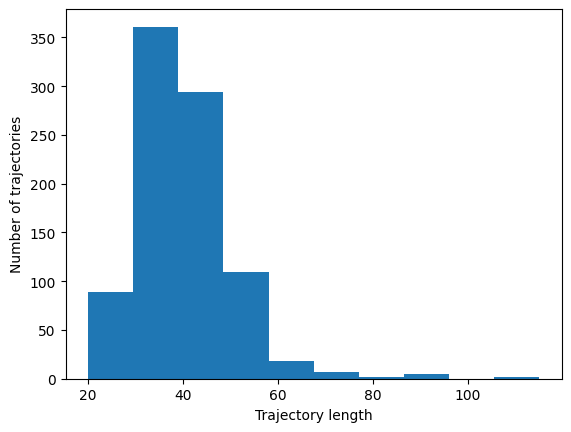

In [38]:
lengths = np.array([len(i) for i in cent_data])
plt.hist(lengths)
plt.xlabel("Trajectory length")
plt.ylabel("Number of trajectories");

In [39]:
# Removing trajectories with <=5 length
idx = np.where(lengths <= 5.)[0]
[labels.pop(j-i) for i,j in enumerate(idx)]
[labels_3d.pop(j-i) for i,j in enumerate(idx)]
[cent_data.pop(j-i) for i,j in enumerate(idx)];

In [40]:
# Checking to see if it worked 
lengths = np.array([len(i) for i in cent_data])
np.where(lengths <= 5.)

(array([], dtype=int64),)

In [41]:
# Train test split
x_train, x_test, y_train, y_test = train_test_split(cent_data, labels, test_size=0.2)
# x_train, x_test, y_train, y_test = train_test_split(cent_data, labels_3d, test_size=0.2)

## Data Augmentation

In [42]:
x_train_aug = []
for idx,i in enumerate(x_train):
    ch = np.random.choice([0,1],p = [0.3,0.7])

    flag = 0 

    if ch == 0: # Perform data augmentation

        trim = len(i)//2

        if trim >= 5: # Trim if the lengths are greater than 5

            aug = i.head(trim)

        else: # If lengths are not greater than 1, don't trim

            aug = i
    else:
        aug = i


    x_train_aug.append(aug)


In [43]:
# Printing out the lengths after and before augmentation
len(x_train_aug), len(x_train)

(709, 709)

## Data Formatting

In [44]:
# Getting the data in the required format for the model
# Creating labels for RNN's output 
y_train = [[dt]*200 for idx,dt in enumerate(y_train)]
y_test = [[dt]*200 for idx,dt in enumerate(y_test)]

In [45]:
# Sequence length is based on data analysis
x_train = tf.convert_to_tensor(tf.keras.preprocessing.sequence.pad_sequences(x_train, padding='post', dtype='float', maxlen=200))
y_train = tf.convert_to_tensor(y_train)

x_test = tf.convert_to_tensor(tf.keras.preprocessing.sequence.pad_sequences(x_test, padding='post', dtype='float', maxlen=200))
y_test = tf.convert_to_tensor(y_test)

In [46]:
# One hot encoding the data for training - not required for label_3d
y_train = tf.one_hot(y_train, 9, on_value = 1.0, off_value = 0.0)
y_test = tf.one_hot(y_test, 9, on_value = 1.0, off_value = 0.0)

## Models

### Creating the RNN model

In [51]:
hidden_size= 10
tf.keras.backend.clear_session()
seq_input = tf.keras.Input(shape=x_train.shape[1:], name='input_layer')


ip_reform = tf.keras.layers.Dense(hidden_size)

ip_reformed = ip_reform(seq_input)

RNN_1 = tf.keras.layers.SimpleRNN(hidden_size, return_sequences=True)
h_1 = RNN_1(ip_reformed)

RNN_2 = tf.keras.layers.SimpleRNN(hidden_size, return_sequences=True)
h_2 = RNN_2(h_1)


dense_2 = tf.keras.layers.Dense(9, activation='softmax')
output = dense_2(h_2)

model_RNN = tf.keras.models.Model(inputs=seq_input, outputs=output)

model_RNN.compile(loss='categorical_crossentropy', metrics = ['accuracy'], optimizer=Adam(1e-2))

### Creating the RNN model - labels_3d

In [52]:
hidden_size= 10
tf.keras.backend.clear_session()
seq_input = tf.keras.Input(shape=x_train.shape[1:], name='input_layer')


ip_reform = tf.keras.layers.Dense(hidden_size)

ip_reformed = ip_reform(seq_input)

RNN_1 = tf.keras.layers.SimpleRNN(hidden_size, return_sequences=True)
h_1 = RNN_1(ip_reformed)

RNN_2 = tf.keras.layers.SimpleRNN(hidden_size, return_sequences=True)
h_2 = RNN_2(h_1)


dense_2 = tf.keras.layers.Dense(3, activation='linear')
output = dense_2(h_2)

model_RNN_3d = tf.keras.models.Model(inputs=seq_input, outputs=output)

model_RNN_3d.compile(loss='mse', metrics = ['mse'], optimizer=Adam(1e-2))

### Creating the LSTM model

In [53]:
hidden_size= 15
tf.keras.backend.clear_session()
seq_input = tf.keras.Input(shape=x_train.shape[1:], name='input_layer')

ip_reform = tf.keras.layers.Dense(hidden_size)

ip_reformed = ip_reform(seq_input)

LSTM = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
h = LSTM(ip_reformed)

dense = tf.keras.layers.Dense(9, activation='softmax')
output = dense(h)

model_LSTM = tf.keras.models.Model(inputs=seq_input, outputs=output)

model_LSTM.compile(loss='categorical_crossentropy', metrics = ['accuracy'], optimizer=Adam(1e-2))

### Creating the LSTM model - labels_3d

In [29]:
hidden_size= 15
tf.keras.backend.clear_session()
seq_input = tf.keras.Input(shape=x_train.shape[1:], name='input_layer')

ip_reform = tf.keras.layers.Dense(hidden_size)

ip_reformed = ip_reform(seq_input)

LSTM = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
h = LSTM(ip_reformed)

dense = tf.keras.layers.Dense(3, activation='linear')
output = dense(h)

model_LSTM_3d = tf.keras.models.Model(inputs=seq_input, outputs=output)

model_LSTM_3d.compile(loss='mse', metrics = ['mse'],optimizer=Adam(1e-2))

### Creating the LSTM+RNN model

In [70]:
hidden_size= 15
tf.keras.backend.clear_session()
seq_input = tf.keras.Input(shape=x_train.shape[1:], name='input_layer')

ip_reform = tf.keras.layers.Dense(hidden_size)

ip_reformed = ip_reform(seq_input)

RNN = tf.keras.layers.SimpleRNN(hidden_size, return_sequences=True)
h_1 = RNN(ip_reformed)

LSTM = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
h_2 = LSTM(h_1)

dense = tf.keras.layers.Dense(9, activation='softmax')
output = dense(h_2)

model_RNN_LSTM = tf.keras.models.Model(inputs=seq_input, outputs=output)

model_RNN_LSTM.compile(loss='categorical_crossentropy', metrics = ['accuracy'], optimizer=Adam(1e-2))

### Creating the LSTM+RNN model - labels_3d

In [31]:
hidden_size= 15
tf.keras.backend.clear_session()
seq_input = tf.keras.Input(shape=x_train.shape[1:], name='input_layer')

ip_reform = tf.keras.layers.Dense(hidden_size)

ip_reformed = ip_reform(seq_input)

RNN = tf.keras.layers.SimpleRNN(hidden_size, return_sequences=True)
h_1 = RNN(ip_reformed)

LSTM = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
h_2 = LSTM(h_1)

dense = tf.keras.layers.Dense(3, activation='linear')
output = dense(h_2)

model_RNN_LSTM_3d = tf.keras.models.Model(inputs=seq_input, outputs=output)

model_RNN_LSTM_3d.compile(loss='mse', metrics = ['mse'], optimizer=Adam(1e-2))

In [69]:
model_LSTM.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 200, 3)]          0         
                                                                 
 dense (Dense)               (None, 200, 15)           60        
                                                                 
 lstm (LSTM)                 (None, 200, 15)           1860      
                                                                 
 dense_1 (Dense)             (None, 200, 9)            144       
                                                                 
Total params: 2,064
Trainable params: 2,064
Non-trainable params: 0
_________________________________________________________________


In [72]:
callbacks = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=100,
    restore_best_weights = True
)

In [73]:
history = model_RNN_LSTM.fit(x_train,y_train, epochs=1000, batch_size=16, validation_split=0.2,callbacks = [callbacks])

Epoch 1/1000


2022-12-12 12:27:36.962874: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x563779732870 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2022-12-12 12:27:36.962896: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): Tesla V100-SXM2-32GB, Compute Capability 7.0
2022-12-12 12:27:36.967191: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2022-12-12 12:27:37.081779: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


36/36 [==============================] - 6s 97ms/step - loss: 2.2071 - accuracy: 0.1029 - val_loss: 2.2136 - val_accuracy: 0.1036
Epoch 2/1000
36/36 [==============================] - 3s 85ms/step - loss: 2.1965 - accuracy: 0.1277 - val_loss: 2.1989 - val_accuracy: 0.1338
Epoch 3/1000
36/36 [==============================] - 3s 85ms/step - loss: 2.1904 - accuracy: 0.1319 - val_loss: 2.2066 - val_accuracy: 0.1260
Epoch 4/1000
36/36 [==============================] - 3s 85ms/step - loss: 2.1845 - accuracy: 0.1312 - val_loss: 2.1825 - val_accuracy: 0.1268
Epoch 5/1000
36/36 [==============================] - 3s 85ms/step - loss: 1.9095 - accuracy: 0.1756 - val_loss: 1.6946 - val_accuracy: 0.2362
Epoch 6/1000
36/36 [==============================] - 3s 85ms/step - loss: 1.7227 - accuracy: 0.2195 - val_loss: 1.7187 - val_accuracy: 0.2272
Epoch 7/1000
36/36 [==============================] - 3s 85ms/step - loss: 1.6847 - accuracy: 0.2081 - val_loss: 1.7014 - val_accuracy: 0.2273
Epoch 8/1000

36/36 [==============================] - 3s 86ms/step - loss: 0.6463 - accuracy: 0.7463 - val_loss: 0.6196 - val_accuracy: 0.7849
Epoch 59/1000
36/36 [==============================] - 3s 85ms/step - loss: 0.7380 - accuracy: 0.6950 - val_loss: 0.6351 - val_accuracy: 0.7863
Epoch 60/1000
36/36 [==============================] - 3s 86ms/step - loss: 0.7154 - accuracy: 0.7119 - val_loss: 0.6130 - val_accuracy: 0.8173
Epoch 61/1000
36/36 [==============================] - 3s 85ms/step - loss: 0.6395 - accuracy: 0.7650 - val_loss: 0.5885 - val_accuracy: 0.7882
Epoch 62/1000
36/36 [==============================] - 3s 86ms/step - loss: 0.6329 - accuracy: 0.7576 - val_loss: 0.5827 - val_accuracy: 0.8049
Epoch 63/1000
36/36 [==============================] - 3s 85ms/step - loss: 0.6319 - accuracy: 0.7431 - val_loss: 0.5844 - val_accuracy: 0.7816
Epoch 64/1000
36/36 [==============================] - 3s 85ms/step - loss: 0.5950 - accuracy: 0.7666 - val_loss: 0.5497 - val_accuracy: 0.8049
Epoch 

Epoch 115/1000
36/36 [==============================] - 3s 86ms/step - loss: 0.3426 - accuracy: 0.8773 - val_loss: 0.3367 - val_accuracy: 0.8782
Epoch 116/1000
36/36 [==============================] - 3s 87ms/step - loss: 0.3400 - accuracy: 0.8777 - val_loss: 0.3348 - val_accuracy: 0.8806
Epoch 117/1000
36/36 [==============================] - 3s 86ms/step - loss: 0.3386 - accuracy: 0.8789 - val_loss: 0.3344 - val_accuracy: 0.8798
Epoch 118/1000
36/36 [==============================] - 3s 87ms/step - loss: 0.3367 - accuracy: 0.8792 - val_loss: 0.3304 - val_accuracy: 0.8819
Epoch 119/1000
36/36 [==============================] - 3s 86ms/step - loss: 0.3650 - accuracy: 0.8672 - val_loss: 0.3490 - val_accuracy: 0.8803
Epoch 120/1000
36/36 [==============================] - 3s 86ms/step - loss: 0.4302 - accuracy: 0.8469 - val_loss: 0.3458 - val_accuracy: 0.8797
Epoch 121/1000
36/36 [==============================] - 3s 86ms/step - loss: 0.4943 - accuracy: 0.8203 - val_loss: 0.3808 - val_ac

36/36 [==============================] - 3s 86ms/step - loss: 0.3011 - accuracy: 0.8876 - val_loss: 0.2970 - val_accuracy: 0.8858
Epoch 172/1000
36/36 [==============================] - 3s 87ms/step - loss: 0.2993 - accuracy: 0.8876 - val_loss: 0.2987 - val_accuracy: 0.8876
Epoch 173/1000
36/36 [==============================] - 3s 86ms/step - loss: 0.2984 - accuracy: 0.8875 - val_loss: 0.2978 - val_accuracy: 0.8872
Epoch 174/1000
36/36 [==============================] - 3s 87ms/step - loss: 0.2974 - accuracy: 0.8884 - val_loss: 0.2933 - val_accuracy: 0.8877
Epoch 175/1000
36/36 [==============================] - 3s 87ms/step - loss: 0.2980 - accuracy: 0.8876 - val_loss: 0.2975 - val_accuracy: 0.8874
Epoch 176/1000
36/36 [==============================] - 3s 86ms/step - loss: 0.3002 - accuracy: 0.8864 - val_loss: 0.3028 - val_accuracy: 0.8826
Epoch 177/1000
36/36 [==============================] - 3s 87ms/step - loss: 0.2977 - accuracy: 0.8875 - val_loss: 0.2947 - val_accuracy: 0.8887


36/36 [==============================] - 3s 87ms/step - loss: 0.2966 - accuracy: 0.8899 - val_loss: 0.2886 - val_accuracy: 0.8887
Epoch 235/1000
36/36 [==============================] - 3s 87ms/step - loss: 0.2961 - accuracy: 0.8889 - val_loss: 0.2890 - val_accuracy: 0.8898
Epoch 236/1000
36/36 [==============================] - 3s 87ms/step - loss: 0.2934 - accuracy: 0.8896 - val_loss: 0.2872 - val_accuracy: 0.8901
Epoch 237/1000
36/36 [==============================] - 3s 87ms/step - loss: 0.2925 - accuracy: 0.8907 - val_loss: 0.2893 - val_accuracy: 0.8879
Epoch 238/1000
36/36 [==============================] - 3s 87ms/step - loss: 0.2906 - accuracy: 0.8916 - val_loss: 0.2875 - val_accuracy: 0.8905
Epoch 239/1000
36/36 [==============================] - 3s 87ms/step - loss: 0.2915 - accuracy: 0.8898 - val_loss: 0.2826 - val_accuracy: 0.8929
Epoch 240/1000
36/36 [==============================] - 3s 87ms/step - loss: 0.2895 - accuracy: 0.8911 - val_loss: 0.2857 - val_accuracy: 0.8904


36/36 [==============================] - 3s 87ms/step - loss: 0.2771 - accuracy: 0.8954 - val_loss: 0.2741 - val_accuracy: 0.8972
Epoch 291/1000
36/36 [==============================] - 3s 87ms/step - loss: 0.2751 - accuracy: 0.8951 - val_loss: 0.2757 - val_accuracy: 0.8969
Epoch 292/1000
36/36 [==============================] - 3s 87ms/step - loss: 0.2736 - accuracy: 0.8958 - val_loss: 0.2785 - val_accuracy: 0.8946
Epoch 293/1000
36/36 [==============================] - 3s 87ms/step - loss: 0.2749 - accuracy: 0.8969 - val_loss: 0.2759 - val_accuracy: 0.8947
Epoch 294/1000
36/36 [==============================] - 3s 87ms/step - loss: 0.2746 - accuracy: 0.8958 - val_loss: 0.3037 - val_accuracy: 0.8920
Epoch 295/1000
36/36 [==============================] - 3s 87ms/step - loss: 0.2724 - accuracy: 0.8964 - val_loss: 0.2851 - val_accuracy: 0.8929
Epoch 296/1000
36/36 [==============================] - 3s 87ms/step - loss: 0.2728 - accuracy: 0.8970 - val_loss: 0.2738 - val_accuracy: 0.8973


36/36 [==============================] - 3s 86ms/step - loss: 0.6096 - accuracy: 0.7715 - val_loss: 0.4396 - val_accuracy: 0.8476
Epoch 347/1000
36/36 [==============================] - 3s 87ms/step - loss: 0.5124 - accuracy: 0.8131 - val_loss: 0.4177 - val_accuracy: 0.8422
Epoch 348/1000
36/36 [==============================] - 3s 86ms/step - loss: 0.7716 - accuracy: 0.7306 - val_loss: 0.7695 - val_accuracy: 0.7301
Epoch 349/1000
36/36 [==============================] - 3s 87ms/step - loss: 0.5619 - accuracy: 0.7537 - val_loss: 0.5146 - val_accuracy: 0.7423
Epoch 350/1000
36/36 [==============================] - 3s 86ms/step - loss: 0.4803 - accuracy: 0.8328 - val_loss: 0.4698 - val_accuracy: 0.8657
Epoch 351/1000
36/36 [==============================] - 3s 87ms/step - loss: 0.5050 - accuracy: 0.8354 - val_loss: 0.4203 - val_accuracy: 0.8669
Epoch 352/1000
36/36 [==============================] - 3s 86ms/step - loss: 0.3996 - accuracy: 0.8616 - val_loss: 0.3717 - val_accuracy: 0.8636


36/36 [==============================] - 3s 86ms/step - loss: 0.2699 - accuracy: 0.8973 - val_loss: 0.2723 - val_accuracy: 0.8998
Epoch 403/1000
36/36 [==============================] - 3s 87ms/step - loss: 0.2714 - accuracy: 0.8968 - val_loss: 0.2722 - val_accuracy: 0.8968
Epoch 404/1000
36/36 [==============================] - 3s 86ms/step - loss: 0.2693 - accuracy: 0.8981 - val_loss: 0.2715 - val_accuracy: 0.8974
Epoch 405/1000
36/36 [==============================] - 3s 87ms/step - loss: 0.2708 - accuracy: 0.8970 - val_loss: 0.2756 - val_accuracy: 0.8954
Epoch 406/1000
36/36 [==============================] - 3s 87ms/step - loss: 0.2675 - accuracy: 0.8984 - val_loss: 0.2755 - val_accuracy: 0.8948
Epoch 407/1000
36/36 [==============================] - 3s 87ms/step - loss: 0.2676 - accuracy: 0.8986 - val_loss: 0.2786 - val_accuracy: 0.8889
Epoch 408/1000
36/36 [==============================] - 3s 86ms/step - loss: 0.2672 - accuracy: 0.8981 - val_loss: 0.2695 - val_accuracy: 0.8991


In [160]:
# conf = []
# for i in predictions:
#     softmax = []
#     for j in i:
#         dist = np.linalg.norm(target-j,axis =1)
#         softmax.append(np.exp(dist)/np.sum(np.exp(dist)))
#     conf.append(softmax)

In [75]:
# model_LSTM.save("/content/drive/MyDrive/Robot perception /Modeling/models/lstm_data_trim.h5")
# model_LSTM.save("/content/drive/MyDrive/Robot perception /Modeling/models/lstm.h5")
model_RNN_LSTM.save("./models/sep_0.7/lstm_rnn.h5")

In [79]:
# Testing the saved model
# classification models
# model_load = load_model('/content/drive/MyDrive/Robot perception /Modeling/models/lstm_data_trim.h5')
# model_load = load_model('/content/drive/MyDrive/Robot perception /Modeling/models/lstm.h5')
# model_load = load_model('./models/lstm_rnn.h5')
model_load = load_model('./models/sep_0.7/lstm_rnn.h5')


# 3d models
# model_load = load_model('./models/sep_1/lstm_3d.h5')
# model_load = load_model('./models/sep_1/lstm_rnn_3d.h5', compile=False)



In [80]:
# Model evaluation for classification
# model_load.compile(loss='categorical_crossentropy', metrics = ['accuracy'], optimizer=Adam(1e-2))
# Evaluating classification models
model_load.evaluate(x_test,y_test)

6/6 [==============================] - 0s 4ms/step - loss: 0.4029 - accuracy: 0.8769


[0.40291428565979004, 0.8769382238388062]

In [51]:
# Model evaluation for 3d 
# model_load.compile(loss='mse', metrics = ['mse'])
predictions = model_load.predict(x_test)
preds = [[np.argmin(np.linalg.norm(target-j,axis =1)) for j in i] for i in predictions]
label_y_test = [[np.argmin(np.linalg.norm(target-j,axis =1)) for j in i] for i in y_test.numpy()]
correct = 0
for i,j in zip(preds,label_y_test):
    for k,l in zip(i,j):
        correct+=np.sum((k==l)*1)
print("Accuracy:", correct/np.prod(np.shape(preds)) )

2022-12-11 18:28:11.923356: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2022-12-11 18:28:18.451829: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8101


Accuracy: 0.8233830845771144


In [52]:
model_load.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 200, 3)]          0         
_________________________________________________________________
dense (Dense)                (None, 200, 15)           60        
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 200, 15)           465       
_________________________________________________________________
lstm (LSTM)                  (None, 200, 15)           1860      
_________________________________________________________________
dense_1 (Dense)              (None, 200, 3)            48        
Total params: 2,433
Trainable params: 2,433
Non-trainable params: 0
_________________________________________________________________
